1. Using the titanic data gotten from kaggle, and with your current knowledge of any of the classification models you are familiar with, perform a classification algorithm to determine passengers that are most likely to survive the titanic crash
Link to Data: Titanic dataset (kaggle.com)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os

df = pd.read_csv('titanic.csv')
# print(f'\ninitial header: {df.columns.tolist()}')
df.insert(0, 'passengerId', range(1, len(df) + 1))
# print(f'new header: {df.columns.tolist()}')
# print(df.dtypes)
# print(df.head())


cols_keep = ["passengerId","sex","age","sibsp","parch","fare","embarked","survived","class"]
df = df[cols_keep]
# print(df.columns)

# Preprocessing setup
numeric_features = ["age","sibsp","parch","fare"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_features = ["sex","embarked"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Prepare X, y
X = df.drop(columns=["passengerId","survived"])
y = df["survived"]

x_pre = preprocessor.fit_transform(X)

cat_names = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

x_train, x_test, y_train, y_test = train_test_split(x_pre, y, test_size=0.2, random_state=42, stratify=y)

# Models
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

lr.fit(x_train, y_train)
rf.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)
y_proba_lr = lr.predict_proba(x_test)[:, 1]
y_pred_rf = rf.predict(x_test)
y_proba_rf = rf.predict_proba(x_test)[:, 1]

def eval_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        # plt.figure()
        # plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title(f'ROC Curve - {name}')
        # plt.legend(loc='lower right')
        # plt.show()

eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf)

print("\nCross-val (5-fold) accuracy:")
print("LogReg:", cross_val_score(lr, x_pre, y, cv=5, scoring="accuracy").mean().round(4))
print("RandomForest:", cross_val_score(rf, x_pre, y, cv=5, scoring="accuracy").mean().round(4))

importances = rf.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
# plt.figure(figsize=(10,6))
# plt.barh(feat_imp['Feature'], feat_imp['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importances from Random Forest')
# plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
# plt.figure()
# plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (area = {roc_auc_score(y_test, y_proba_lr):.2f})')
# plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_score(y_test, y_proba_rf):.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison')
# plt.legend(loc='lower right')
# plt.show()

x_full_pre = preprocessor.transform(df.drop(columns=["passengerId","survived"]))
proba_all_rf = rf.predict_proba(x_full_pre)[:, 1]
output = pd.DataFrame({'passengerId': df['passengerId'], 'survived_Prob_RF': proba_all_rf})
output = pd.merge(df, output, on='passengerId')
output.to_csv('results.csv', index=False)
# output.to_csv('titanic_survival_probabilities.csv', index=False)

print("\nPredictions saved to 'results.csv'")

2. Using the dataset provided, build a model to classify emails as spam or not spam.
Link to Data:  Spam Mails Dataset (kaggle.com)

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


/root/miniconda3/envs/pyint_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:55:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1199, number of negative: 2937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58667
[LightGBM] [Info] Number of data points in the train set: 4136, number of used features: 2294
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289894 -> initscore=-0.895901
[LightGBM] [Info] Start training from score -0.895901


/root/miniconda3/envs/pyint_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/root/miniconda3/envs/pyint_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Logistic Regression Results
Accuracy: 0.991304347826087
ROC AUC: 0.9996643990929706
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       735
           1       0.97      1.00      0.99       300

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035

Confusion Matrix:
 [[727   8]
 [  1 299]]

Naive Bayes Results
Accuracy: 0.9256038647342996
ROC AUC: 0.9981451247165534
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       735
           1       1.00      0.74      0.85       300

    accuracy                           0.93      1035
   macro avg       0.95      0.87      0.90      1035
weighted avg       0.93      0.93      0.92      1035

Confusion Matrix:
 [[735   0]
 [ 77 223]]

XGBoost Results
Accuracy: 0.978743961352657
ROC AUC: 0.9967732426303855
              precision   

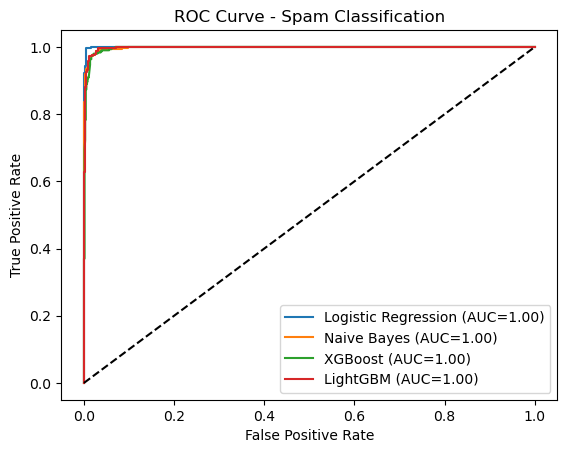


Cross-validation scores:
Logistic Regression: 0.9884
Naive Bayes: 0.9197
model name: logistic regression:
Email: Congratulations! You've won a $1,000 Walmart gift card. Click here to claim your prize.
Predicted: SPAM (probability 0.71)
Email: Hi John, are we still on for the meeting tomorrow?
Predicted: NOT SPAM (probability 0.36)
Email: URGENT! Your account has been compromised. Please reset your password immediately.
Predicted: NOT SPAM (probability 0.56)
Email: Hey, just checking in to see how you're doing.
Predicted: NOT SPAM (probability 0.48)
Email: hi bro, do you still care for the loan?
Predicted: SPAM (probability 0.66)
Email: You have a new voicemail. Call now to listen to your messages.
Predicted: NOT SPAM (probability 0.54)
...............................................................

model name: naive bayes:
Email: Congratulations! You've won a $1,000 Walmart gift card. Click here to claim your prize.
Predicted: NOT SPAM (probability 0.47)
Email: Hi John, are we still 

/root/miniconda3/envs/pyint_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [1]:
# Step 1: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# Step 2: Load dataset
df = pd.read_csv("spam_ham_dataset.csv")   # adjust filename if different
print(df.head())
df['text'] = df['text'].astype(str)  # Ensure text column is string
# print(df['Category'].value_counts())

# Dataset typically has "Category" (ham/spam) and "Message"
# Rename for convenience
df = df.rename(columns={"Category": "label", "Message": "text"})

# Encode labels: ham=0, spam=1
df['label'] = df['label'].map({"ham": 0, "spam": 1})

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Step 4: Build pipelines

# Logistic Regression with TF-IDF
lr_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

xgb_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

lgbm_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LGBMClassifier(random_state=42))
])

# Naive Bayes with TF-IDF
nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

# Step 5: Train models
lr_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)

# Step 6: Predictions
def model_predictions(model, X_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba
y_pred_lr, y_proba_lr = model_predictions(lr_clf, X_test)
y_pred_nb, y_proba_nb = model_predictions(nb_clf, X_test)
y_pred_xgb, y_proba_xgb = model_predictions(xgb_clf, X_test)
y_pred_lgbm, y_proba_lgbm = model_predictions(lgbm_clf, X_test)

# y_pred_lr = lr_clf.predict(X_test)
# y_proba_lr = lr_clf.predict_proba(X_test)[:, 1]

# y_pred_nb = nb_clf.predict(X_test)
# y_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

# Step 7: Evaluation function
def eval_model(name, y_true, y_pred, y_proba):
    print(f"\n{name} Results")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_true, y_proba):.2f})')

# Step 8: Evaluate both models
eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
eval_model("Naive Bayes", y_test, y_pred_nb, y_proba_nb)
eval_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
eval_model("LightGBM", y_test, y_pred_lgbm, y_proba_lgbm)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Spam Classification")
plt.legend()
plt.show()

# Step 9: Cross-validation (for robustness)
print("\nCross-validation scores:")
print("Logistic Regression:", cross_val_score(lr_clf, df['text'], df['label'], cv=5).mean().round(4))
print("Naive Bayes:", cross_val_score(nb_clf, df['text'], df['label'], cv=5).mean().round(4))


# Example emails to test
test_emails = [
    "Congratulations! You've won a $1,000 Walmart gift card. Click here to claim your prize.",
    "Hi John, are we still on for the meeting tomorrow?",
    "URGENT! Your account has been compromised. Please reset your password immediately.",
    "Hey, just checking in to see how you're doing.",
    "hi bro, do you still care for the loan?",
    "You have a new voicemail. Call now to listen to your messages."
]

# Predict with Logistic Regression model
threshold = 0.6
probs = lr_clf.predict_proba(test_emails)[:, 1]  # probability of spam
probs_nb = nb_clf.predict_proba(test_emails)[:, 1]
probs_xgb = xgb_clf.predict_proba(test_emails)[:, 1]
probs_lgbm = lgbm_clf.predict_proba(test_emails)[:, 1]
# preds = lr_clf.predict(test_emails)
preds = (probs >= threshold).astype(int)  # apply threshold
preds_nb = (probs_nb >= threshold).astype(int)
preds_xgb = (probs_xgb >= threshold).astype(int)
preds_lgbm = (probs_lgbm >= threshold).astype(int)

def is_spam(model_name,test_emails, preds, probs):
    print(f'model name: {model_name}:')
    for email, label, prob in zip(test_emails, preds, probs):
        print(f"Email: {email}")
        print(f"Predicted: {'SPAM' if label == 1 else 'NOT SPAM'} (probability {prob:.2f})")
    print("...............................................................\n")
is_spam("logistic regression",test_emails, preds, probs)
is_spam("naive bayes",test_emails, preds_nb, probs_nb)
is_spam("LightGBM",test_emails, preds_lgbm, probs_lgbm)
is_spam("XGBoost",test_emails, preds_xgb, probs_xgb)

using fastai

In [ ]:

import pandas as pd
from fastai.text.all import *


df = pd.read_csv("spam_ham_dataset.csv")
print(df.columns)
df = df.rename(columns={"Category": "label", "Message": "text"})
# Encode labels: ham=0, spam=1
df['label'] = df['label'].map({"ham": 0, "spam": 1})


splits = RandomSplitter(seed=42)(range_of(df))

# Create DataBlock
# dblock = DataBlock(
#     blocks=(TextBlock.from_df('text', is_lm=False), CategoryBlock),
#     get_y=ColReader('label'),
#     splitter=IndexSplitter(splits[1])
# )
# Create DataBlock with proper splitter
dblock = DataBlock(
    blocks=(TextBlock.from_df('text', is_lm=False), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls = dblock.dataloaders(df, bs=32)

# Build a text classifier using AWD_LSTM
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, RocAuc()])
learn.fine_tune(4)  # you can increase epochs if needed

# test emails to make predictions on
test_emails = [
    "Congratulations! You've won a $1,000 Walmart gift card. Click here to claim your prize.",
    "Hi John, are we still on for the meeting tomorrow?",
    "URGENT! Your account has been compromised. Please reset your password immediately.",
    "Hey, just checking in to see how you're doing.",
    "hi bro, do you still care for the loan?",
    "You have a new voicemail. Call now to listen to your messages."
]

# custom threshold for spam
threshold = 0.6

for email in test_emails:
    pred, pred_idx, probs = learn.predict(email)
    prob_spam = float(probs[1])
    label = 1 if prob_spam >= threshold else 0
    print(f"\nEmail: {email}")
    print(f"Predicted: {'SPAM' if label == 1 else 'NOT SPAM'} (probability {prob_spam:.2f})")


Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time


ValueError: Exception occured in `Recorder` when calling event `after_validate`:
	y should be a 1d array, got an array of shape (1034, 2) instead.

: 